In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive  #using the google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [134]:
dataset_train = pd.read_csv("../content/drive/MyDrive/RNN/ACRS(118kb).csv")
dataset_train = dataset_train.sort_values(by='Date').reset_index(drop=True)
training_set = dataset_train.iloc[:, 5:6].values #predict adj close price
print(dataset_train.shape)
dataset_train

(1130, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-06,11.00,11.00,11.000,11.00,11.00,0
1,2015-10-07,11.94,11.98,11.000,11.05,11.05,1158700
2,2015-10-08,11.14,11.30,10.990,11.05,11.05,125100
3,2015-10-09,11.00,13.98,11.000,12.50,12.50,161900
4,2015-10-12,13.34,14.12,12.500,13.60,13.60,325200
...,...,...,...,...,...,...,...
1125,2020-03-26,1.12,1.17,1.061,1.17,1.17,225500
1126,2020-03-27,1.15,1.15,1.100,1.13,1.13,114200
1127,2020-03-30,1.12,1.12,1.000,1.02,1.02,233800
1128,2020-03-31,1.00,1.17,1.000,1.04,1.04,249600


# **EDA**


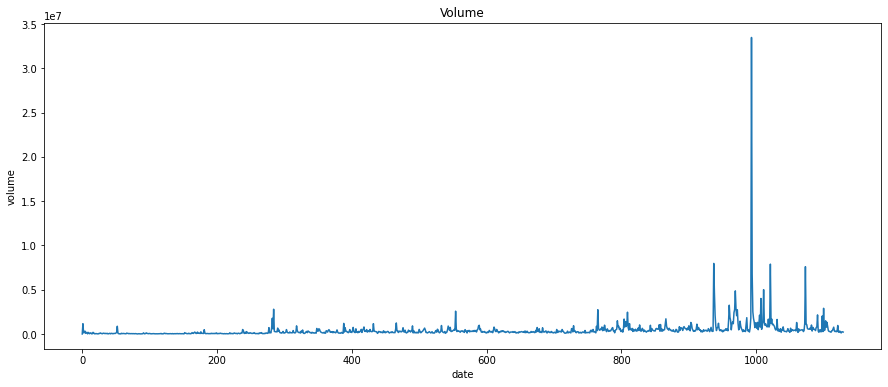

In [135]:
plt.figure(figsize=(15,6))
plt.plot(dataset_train.index,dataset_train.Volume)
plt.xlabel('date')
plt.ylabel('volume')
plt.title("Volume")
plt.show()

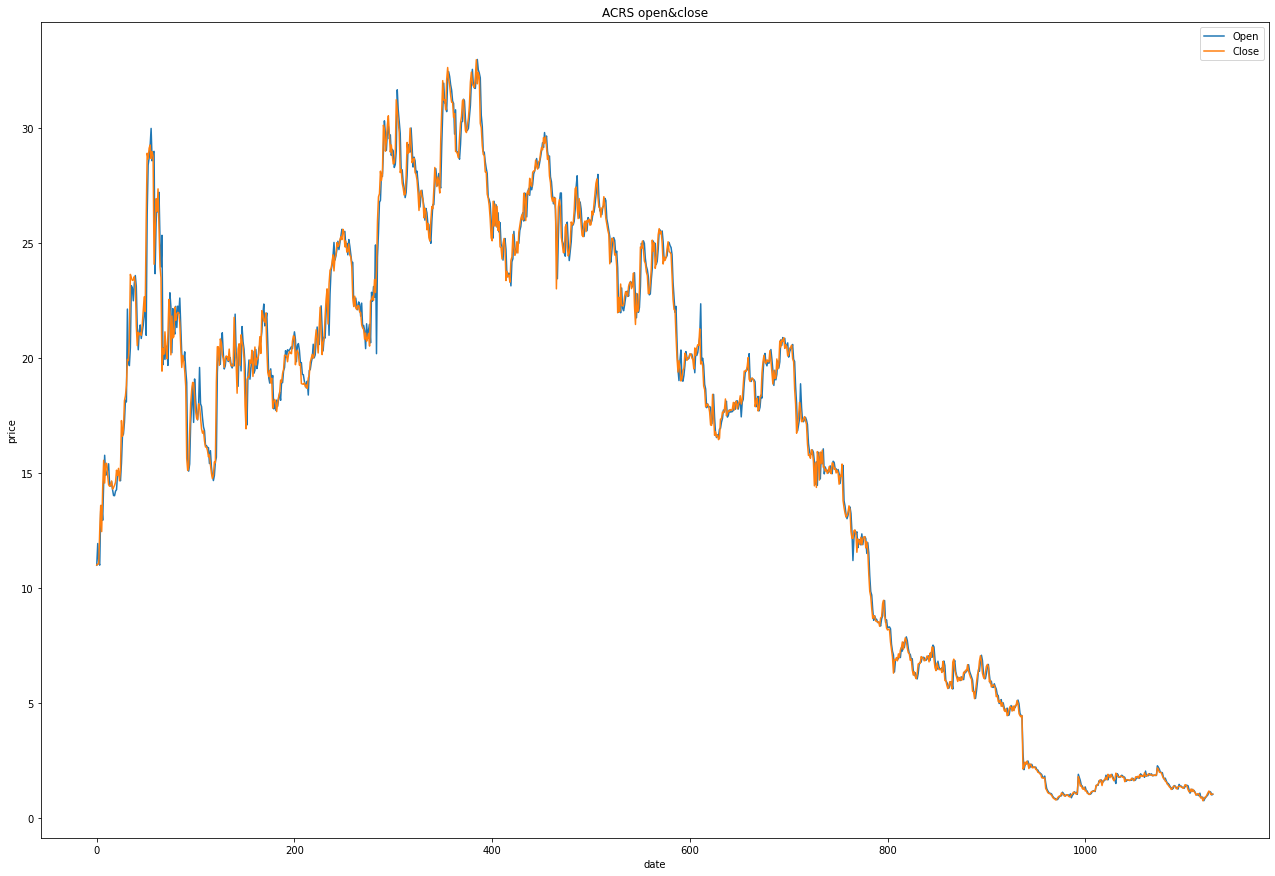

In [136]:
plt.figure(figsize=(22,15))
plt.plot(dataset_train.index,dataset_train.Open,label='Open')
plt.plot(dataset_train.index,dataset_train.Close,label='Close')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.title("ACRS open&close")
plt.show()

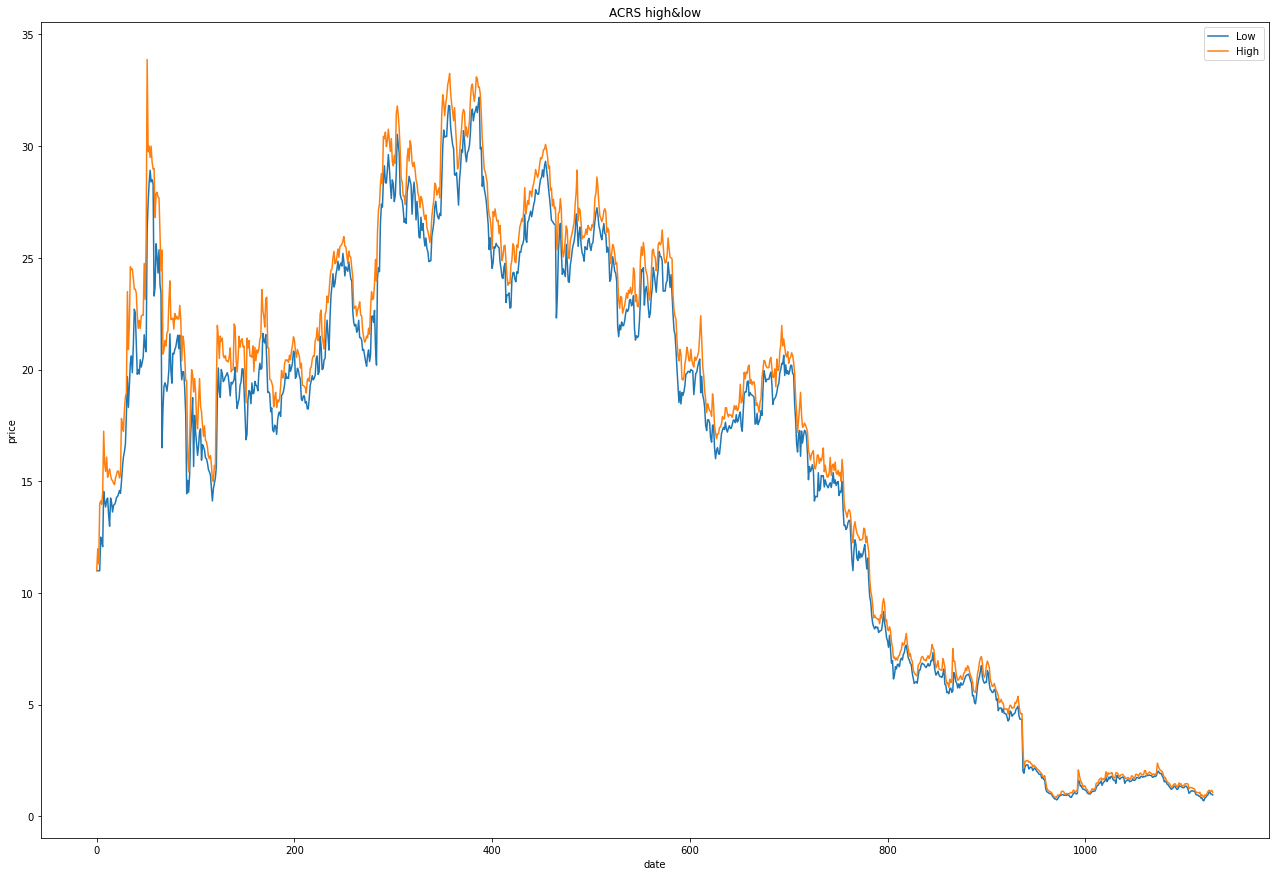

In [137]:
plt.figure(figsize=(22,15))
plt.plot(dataset_train.index,dataset_train.Low,label='Low')
plt.plot(dataset_train.index,dataset_train.High,label='High')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.title("ACRS high&low")
plt.show()

# **set time steps**

In [138]:
time_window = 10

正则化

In [139]:
training_set

array([[11.        ],
       [11.05000019],
       [11.05000019],
       ...,
       [ 1.01999998],
       [ 1.03999996],
       [ 1.03999996]])

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [141]:
train_size = int((len(training_set)-time_window) * 0.8)

In [142]:
test_size = len(training_set) - train_size - time_window

In [143]:
print(train_size)
print(test_size)


896
224


In [144]:
fitted_transformer = scaler.fit(training_set[:train_size+time_window])

In [145]:
data_scaled = fitted_transformer.transform(training_set)

In [146]:
data_scaled

array([[ 0.20899279],
       [ 0.21079136],
       [ 0.21079136],
       ...,
       [-0.14999999],
       [-0.14928057],
       [-0.14928057]])

In [147]:
type(training_set)

numpy.ndarray

In [148]:
data_scaled.shape

(1130, 1)

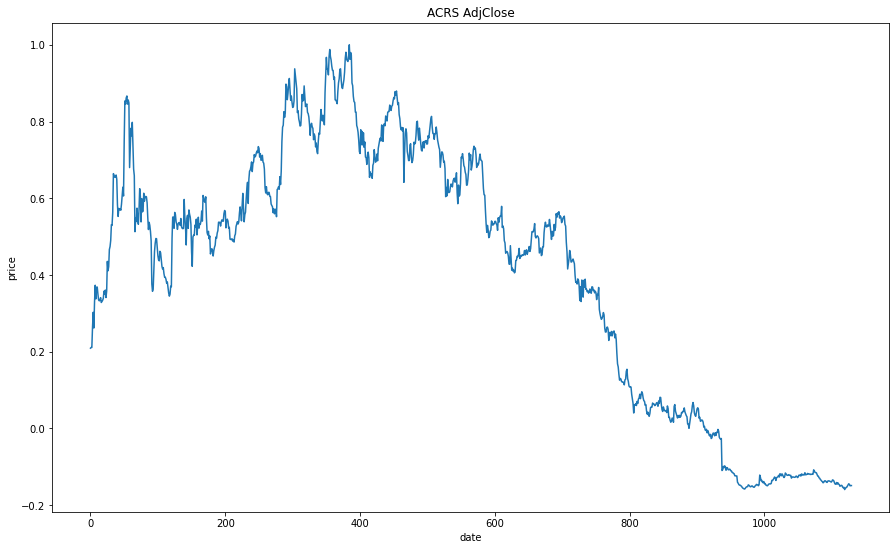

In [149]:
plt.figure(figsize=(15,9))
plt.plot(dataset_train.index,data_scaled)
plt.title("ACRS AdjClose")
plt.xlabel('date')
plt.ylabel('price')
plt.show()

# **Data Splitting**

In [150]:
# Pre-allocation
Xall, Yall = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0]) #0~1120
    Yall.append(data_scaled[i, 0]) #10~1130

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)


# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [151]:
print(Xall.shape)
print(Yall.shape)

(1120, 10)
(1120,)


In [152]:
print(Xtrain.shape)
print(Ytrain.shape)

(896, 10)
(896,)


In [153]:
print(Xtest.shape)
print(Ytest.shape)

(224, 10)
(224,)


# **build RNN model**

In [188]:

# build RNN using keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,Activation
from keras.layers import Dropout


regressor = Sequential()

# hiden layer 1
regressor.add(SimpleRNN(units = 5, input_shape = (Xtrain.shape[1], 1)))
# regressor.add(Dropout(0.15))

# hiden layer 2
# regressor.add(SimpleRNN(units = 100,return_sequences=True,))
# regressor.add(Dropout(0.15))

#regressor.add(Activation('softmax'))

# output layer
regressor.add(Dense(units = 1))


# optimizer=adam， loss is MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit model
history = regressor.fit(Xtrain, Ytrain, epochs = 100, batch_size = 32, validation_split=0.2) #用前Xtrain个数作为训练集

regressor.summary()

Epoch 1/100
23/23 [==============================] - 2s 22ms/step - loss: 0.0098 - val_loss: 0.0072
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0093
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 9/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 10/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 11

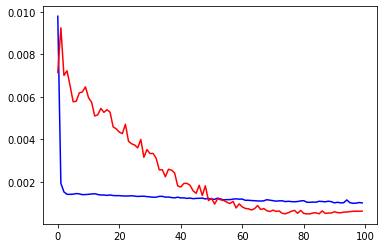

In [200]:
plt.plot(history.history['loss'],c='blue')    # blue = training loss
plt.plot(history.history['val_loss'],c='red') # red = val loss
plt.show()

# **test and validation**

In [191]:
allPredict = regressor.predict(Xall) #predict all

35/35 [==============================] - 0s 2ms/step


In [192]:
allPredictPlot = scaler.inverse_transform(allPredict)

In [193]:
Predict_in = allPredictPlot[:train_size] #in sample 

In [194]:
Predict_out = allPredictPlot[-test_size:] #out of sample

In [195]:
Xall.shape

(1120, 10)

In [196]:
Predict_in.shape

(896, 1)

In [197]:
Predict_out.shape

(224, 1)

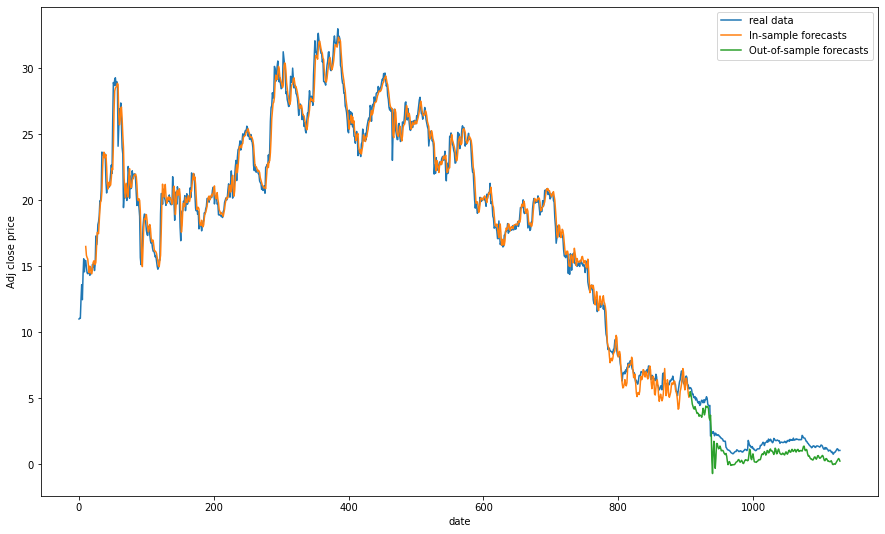

In [201]:
plt.figure(figsize=(15,9))
plt.plot(dataset_train.index, scaler.inverse_transform(data_scaled), label='real data')
plt.plot(dataset_train.index[-(train_size+test_size):-test_size],Predict_in, label='In-sample forecasts')
plt.plot(dataset_train.index[-test_size:],Predict_out, label='Out-of-sample forecasts')
plt.xlabel('date')
plt.ylabel('Adj close price')
plt.legend()
plt.show()

In [202]:
# evaluate the model
RNN_test_error = regressor.evaluate(Xtest, Ytest)
RNN_test_error=('%.4f'%RNN_test_error)
print("The Mean Squared Error of RNN based on out of samples is",RNN_test_error)

7/7 [==============================] - 0s 3ms/step - loss: 0.0011
The Mean Squared Error of RNN based on out of samples is 0.0011
